In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [4]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [6]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:
# len(reduces_groups)

In [8]:
# reduced_groups = mb.tl.reduce_filters([p.to_numpy() for p in pwms[:10]], thr_group=0.03, plot=False)

In [9]:
# reduced_groups = reduced_groups[:4]
# reduced_groups = reduced_groups[:1]

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cuda:0


In [11]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [12]:
import scanpy as sc

In [13]:
# atac_path = '../../../annotations/scatac/ancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
all_path = '../../../annotations/scatac/pancreas_multiome_2022_processed.h5ad'
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_atac.h5ad'
rna_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_rna.h5ad'
if not os.path.exists(atac_path):
    print('preparing atac...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    atac = adata[:,adata.var.modality == 'ATAC'].copy()
    print(atac.shape)
    atac.write(atac_path, compression='lzf')
if not os.path.exists(rna_path):
    print('preparing rna...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    rna = adata[:,adata.var.modality == 'GEX'].copy()
    print(rna.shape)
    rna.write(rna_path, compression='lzf')

In [14]:
atac = sc.read_h5ad(atac_path)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

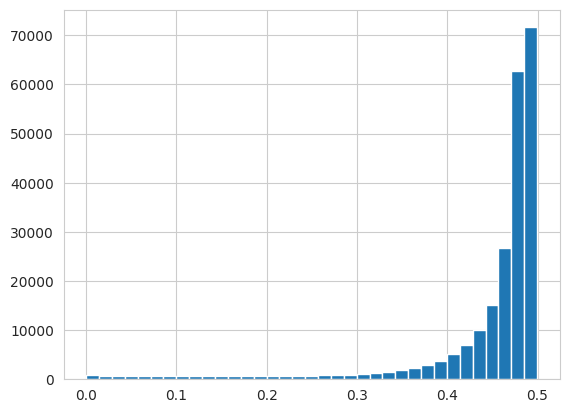

In [15]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [296]:
n_sample_cells = 600
n_sample_peaks = int(n_sample_cells * 1.5)
obs_sample = pd.Series(atac.obs_names).sample(n_sample_cells)
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(600, 900)

In [297]:
ad.obs['celltype'].value_counts()

Ngn3 high            147
Ductal                92
Imm. Acinar           70
Mat. Acinar           43
Prlf. Ductal          43
Fev+                  42
Ngn3 low              39
Fev+ Beta             31
Alpha                 22
Beta                  20
Fev+ Alpha            15
Eps. progenitors      10
Epsilon                9
Fev+ Delta             7
Ngn3 high cycling      7
Delta                  3
Name: celltype, dtype: int64

In [298]:
ad.shape

(600, 900)

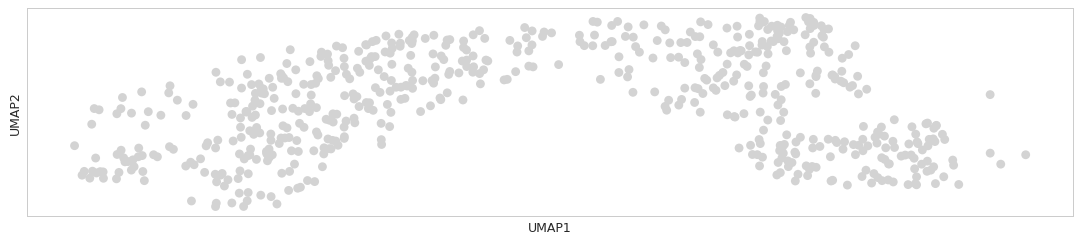

In [299]:
sc.pl.umap(ad)

In [300]:
ad.var

modality  acc_score  acc_score_rank
1-13697253-13698037       ATAC   0.489420         35436.0
1-15923911-15924666       ATAC   0.493143          7749.5
1-16519669-16520094       ATAC   0.199373        218611.5
1-21593678-21594690       ATAC   0.474406        124478.0
1-33179714-33180599       ATAC   0.491488         17515.0
...                        ...        ...             ...
X-161033155-161034044     ATAC   0.473815        126328.0
X-161162397-161163295     ATAC   0.409623        195013.0
X-162201749-162202667     ATAC   0.457501        159968.0
X-169927101-169928066     ATAC   0.480494        100313.0
Y-90744147-90745010       ATAC   0.412224        193971.0

[900 rows x 3 columns]

In [301]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

In [302]:
extend = 50

ad.var['chr'].value_counts()

chr1     65
chr2     64
chr5     60
chr10    59
chr4     58
chr6     58
chr11    50
chr7     49
chr3     49
chr13    48
chr9     47
chr12    45
chr18    42
chr14    37
chr15    37
chr8     33
chr16    33
chr17    29
chr19    20
chrX     16
chrY      1
Name: chr, dtype: int64

In [303]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [304]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

convert bed to fasta
/tmp/tmphcfalhhy
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmphcfalhhy -fo /tmp/tmp1jvh42i9
get fasta
/tmp/tmp1jvh42i9


900

In [305]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [306]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [307]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [308]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(900, 601)

In [309]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [310]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [311]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [312]:
next_data_sel

0    1    2    3    4  \
seq                                                                           
CTCGCGAAAAGTTCTGCCGGAGCTCCGCCCCCTCAGCGCCACAGCGG...  4.0  3.0  3.0  0.0  2.0   
GGTGCAGGAGCCCAGCCAACCCCACAGTAGCGGAGTGCCTGGCGGTG...  2.0  0.0  1.0  0.0  2.0   
ATTCTGGGAAATGTAGTCCTCCCAACGAGGCTGCCCACACGGGACTC...  2.0  1.0  0.0  1.0  0.0   
TCCTGGCCCCTTTGCCAGGGCCTTCCTTATTTGGGCACGGCTCTGAA...  2.0  0.0  2.0  0.0  2.0   
TCCCGCCTTCGTGGGGCGGTGACTGTCACCGCCAGGCGCCGAAGGGA...  1.0  1.0  2.0  0.0  0.0   
...                                                 ...  ...  ...  ...  ...   
AAGCAGTGGGGTGGTATGAGACTTCCACGCATGCATTCCTTGGGATG...  0.0  0.0  0.0  0.0  0.0   
GACTACCACAATTATCAGGATATTTAATAATTGTACATTTAATGAGT...  0.0  0.0  0.0  0.0  0.0   
GATGTAAATTCCTTTGTGATTAAATGAAATTCCAGTGTGTGTGTGTA...  0.0  0.0  0.0  0.0  0.0   
GGACCACGGAAGGTGCGGAAGAGTAGGGGAGCATGTGACATGGAAGT...  0.0  0.0  0.0  0.0  0.0   
GTGAGCATGTGGTGGCACCAACAGCAAAGCAGCAGGTTCCAGCAGTG...  0.0  0.0  0.0  0.0  0.0   

                                                      5    6    7    8    9  \
seq                                                                           
CTCGCGAAAAGTTCTGCCGGAGCTCCGCCCCCTCAGCGCCACAGCGG...  1.0  1.0  3.0  3.0  3.0   
GGTGCAGGAGCCCAGCCAACCCCACAGTAGCGGAGTGCCTGGCGGTG...  1.0  0.0  0.0  0.0  2.0   
ATTCTGGGAAATGTAGTCCTCCCAACGAGGCTGCCCACACGGGACTC...  0.0  0.0  1.0  2.0  1.0   
TCCTGGCCCCTTTGCCAGGGCCTTCCTTATTTGGGCACGGCTCTGAA...  1.0  2.0  1.0  1.0  0.0   
TCCCGCCTTCGTGGGGCGGTGACTGTCACCGCCAGGCGCCGAAGGGA...  0.0  0.0  0.0  2.0  4.0   
...                                                 ...  ...  ...  ...  ...   
AAGCAGTGGGGTGGTATGAGACTTCCACGCATGCATTCCTTGGGATG...  0.0  0.0  0.0  0.0  0.0   
GACTACCACAATTATCAGGATATTTAATAATTGTACATTTAATGAGT...  0.0  0.0  0.0  0.0  0.0   
GATGTAAATTCCTTTGTGATTAAATGAAATTCCAGTGTGTGTGTGTA...  0.0  0.0  0.0  0.0  0.0   
GGACCACGGAAGGTGCGGAAGAGTAGGGGAGCATGTGACATGGAAGT...  0.0  0.0  0.0  0.0  0.0   
GTGAGCATGTGGTGGCACCAACAGCAAAGCAGCAGGTTCCAGCAGTG...  0.0  0.0  0.0  0.0  0.0   

                                                    ...  591  592  593  594  \
seq                                                 ...                       
CTCGCGAAAAGTTCTGCCGGAGCTCCGCCCCCTCAGCGCCACAGCGG...  ...  2.0  0.0  0.0  0.0   
GGTGCAGGAGCCCAGCCAACCCCACAGTAGCGGAGTGCCTGGCGGTG...  ...  1.0  1.0  3.0  1.0   
ATTCTGGGAAATGTAGTCCTCCCAACGAGGCTGCCCACACGGGACTC...  ...  1.0  0.0  1.0  0.0   
TCCTGGCCCCTTTGCCAGGGCCTTCCTTATTTGGGCACGGCTCTGAA...  ...  1.0  0.0  1.0  0.0   
TCCCGCCTTCGTGGGGCGGTGACTGTCACCGCCAGGCGCCGAAGGGA...  ...  1.0  1.0  0.0  0.0   
...                                                 ...  ...  ...  ...  ...   
AAGCAGTGGGGTGGTATGAGACTTCCACGCATGCATTCCTTGGGATG...  ...  0.0  0.0  0.0  0.0   
GACTACCACAATTATCAGGATATTTAATAATTGTACATTTAATGAGT...  ...  0.0  0.0  0.0  0.0   
GATGTAAATTCCTTTGTGATTAAATGAAATTCCAGTGTGTGTGTGTA...  ...  0.0  0.0  0.0  0.0   
GGACCACGGAAGGTGCGGAAGAGTAGGGGAGCATGTGACATGGAAGT...  ...  0.0  0.0  0.0  0.0   
GTGAGCATGTGGTGGCACCAACAGCAAAGCAGCAGGTTCCAGCAGTG...  ...  0.0  0.0  0.0  0.0   

                                                    595  596  597  598  599  \
seq                                                                           
CTCGCGAAAAGTTCTGCCGGAGCTCCGCCCCCTCAGCGCCACAGCGG...  2.0  0.0  5.0  3.0  1.0   
GGTGCAGGAGCCCAGCCAACCCCACAGTAGCGGAGTGCCTGGCGGTG...  0.0  3.0  4.0  0.0  0.0   
ATTCTGGGAAATGTAGTCCTCCCAACGAGGCTGCCCACACGGGACTC...  1.0  1.0  1.0  1.0  0.0   
TCCTGGCCCCTTTGCCAGGGCCTTCCTTATTTGGGCACGGCTCTGAA...  0.0  1.0  0.0  0.0  0.0   
TCCCGCCTTCGTGGGGCGGTGACTGTCACCGCCAGGCGCCGAAGGGA...  0.0  0.0  2.0  3.0  1.0   
...                                                 ...  ...  ...  ...  ...   
AAGCAGTGGGGTGGTATGAGACTTCCACGCATGCATTCCTTGGGATG...  0.0  0.0  0.0  0.0  0.0   
GACTACCACAATTATCAGGATATTTAATAATTGTACATTTAATGAGT...  0.0  0.0  0.0  0.0  0.0   
GATGTAAATTCCTTTGTGATTAAATGAAATTCCAGTGTGTGTGTGTA...  0.0  0.0  0.0  0.0  0.0   
GGACCACGGAAGGTGCGGAAGAGTAGGGGAGCATGTGACATGGAAGT...  0.0  0.0  0.0  0.0  0.0   
GTGAGCATGTGGTGGCACCAAC

In [313]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [314]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(894, 600)

In [315]:
ad = ad[:,~zero_counts].copy()


In [316]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(536400, 3)
600
0      894
137    894
127    894
128    894
129    894
      ... 
69     894
70     894
71     894
72     894
199    894
Name: batch, Length: 200, dtype: int64


0    1  batch
seq                                                                
CTCGCGAAAAGTTCTGCCGGAGCTCCGCCCCCTCAGCGCCACAGCGG...  1.0  4.0      0
GGTGCAGGAGCCCAGCCAACCCCACAGTAGCGGAGTGCCTGGCGGTG...  1.0  2.0      0
ATTCTGGGAAATGTAGTCCTCCCAACGAGGCTGCCCACACGGGACTC...  1.0  2.0      0
TCCTGGCCCCTTTGCCAGGGCCTTCCTTATTTGGGCACGGCTCTGAA...  1.0  2.0      0
TCCCGCCTTCGTGGGGCGGTGACTGTCACCGCCAGGCGCCGAAGGGA...  1.0  1.0      0

### Simple motif enrichment

In [317]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [318]:
import ushuffle

fg = df.index
bg = []

for i, s in enumerate(fg):
    # print(i, s)
    bg.append(ushuffle.shuffle(str.encode(s), 2))



In [319]:
for a, b in zip(fg, bg):
    # print(len(a[1]), len(b))
    assert len(a) == len(b)

In [320]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [321]:
reduced_groups = pwms

In [322]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [323]:
df_neg = df.copy()
df_neg.index = bg
df_neg.index = df_neg.index.astype(str)

dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=1024, shuffle=True)


In [324]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")
criterion = mb.tl.PoissonLoss()

w = [r.shape[1] for r in reduced_groups]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# initialize the reduce kernels
for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    mono_best = mono_best.to_numpy()
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
model = model.to(device)


In [325]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)
mono.shape, mono_rev.shape

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]

# 01 normalize
for ci in range(bm_pred.shape[1]):
    v = bm_pred[:, ci]
    vmin, vmax = v.min(), v.max()
    print(ci, vmin, vmax)
    bm_pred[:, ci] = (v - vmin) / (vmax - vmin)

scores_fg = {}

for ci in range(bm_pred.shape[1]):
    scores_fg[ci] = bm_pred[:, ci]

0 1011.4813 7295.46
1 4533.4604 74417.06
2 1611.6858 6095.024
3 4341.005 24237.547
4 1754.0035 28959.54
5 1561.1321 18106.781
6 6431.0186 68718.984
7 11336.117 644864.1
8 4715.4844 19082.377
9 2905.581 11549.879
10 6636.483 38216.605
11 425.5735 17663.186
12 2350.0112 8669.072
13 5870.0894 102330.4
14 2706.8994 21591.986
15 1915.9763 29810.504
16 5070.6445 385954.16
17 1292.7129 9965.324
18 7180.7188 610274.06
19 5568.1553 163002.86
20 1678.6136 16466.215
21 3588.965 11249.416
22 8293.841 75401.555
23 1964.533 10201.975
24 3225.0154 13816.1455
25 1432.8578 84260.92
26 3055.1245 161899.5
27 1494.136 11372.069
28 6363.825 38137.77
29 2287.027 7849.7363
30 2627.2075 18395.799
31 4722.926 20894.883
32 1198.373 8124.58
33 4108.501 50492.523
34 2114.4211 7126.631
35 3124.3518 85599.47
36 2285.0706 19673.293
37 1952.419 42007.617
38 2092.48 177997.75
39 420.6612 6120410.0
40 1867.3862 24389.23
41 631.59247 7309.8594
42 2373.9873 182408.23
43 5457.5527 229777.08
44 4254.646 215446.81
45 991.11

In [326]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train_neg.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]


In [327]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train_neg.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]

# 01 normalize
for ci in range(bm_pred.shape[1]):
    v = bm_pred[:, ci]
    vmin, vmax = v.min(), v.max()
    print(ci, vmin, vmax)
    bm_pred[:, ci] = (v - vmin) / (vmax - vmin)

scores_bg = {}

for ci in range(bm_pred.shape[1]):
    scores_bg[ci] = bm_pred[:, ci]

0 1003.96967 5793.241
1 4191.661 59968.2
2 1852.4597 8300.428
3 4471.23 33748.938
4 1966.2253 25943.457
5 1464.8755 20292.227
6 6691.8193 84446.92
7 11387.613 419846.5
8 4413.543 15118.797
9 2915.1235 13657.4375
10 5952.635 34425.58
11 409.74228 13052.453
12 2616.6792 7097.481
13 6929.611 33447.785
14 2788.703 23463.635
15 1708.5062 29443.928
16 4329.382 214639.28
17 1321.2068 8674.486
18 8573.957 129372.68
19 7046.645 148906.88
20 1687.1731 10514.258
21 3683.9429 15578.612
22 9420.359 65941.664
23 2041.1365 9334.563
24 3769.2114 13824.279
25 1655.1248 68307.16
26 3913.4016 82122.734
27 1463.752 11642.058
28 5702.398 36736.754
29 2334.8037 6238.4434
30 2989.8623 16480.953
31 4713.987 23275.465
32 1224.8248 7526.0303
33 4230.208 34904.395
34 2070.5322 7756.817
35 2784.4434 112592.35
36 2340.5703 16305.734
37 2216.1914 36620.406
38 2160.7407 114995.6
39 426.07584 4390020.0
40 1779.9878 18858.797
41 667.6131 9215.039
42 3144.8228 93451.73
43 6371.1963 231211.4
44 3892.9563 160302.58
45 10

In [328]:
calc_pwm_scores = False
if calc_pwm_scores:
    from numba import jit

    scores_fg = {}
    scores_bg = {}

    def get_scores(entries, kmers):
        scores = []
        # print(entries[0])
        for s in entries:
            # print(h, s)
            s = str(s)
            base_for = "ACGT"
            base_rev = "TGCA"
            comp_tab = str.maketrans(base_for, base_rev)
            s_rev = s.translate(comp_tab)[::-1]

            seq_score = 0
            for k in kmers:
                if k in s or k in s_rev:
                    seq_score = 1
                    break
            scores.append(seq_score)
        return scores

    @jit
    def get_scores(pwm_vals, nts, cols):
        return np.sum(pwm_vals[nts, cols])

    def get_scores_pwm(entries, pwm):
        scores = []
        pwm_vals = pwm.values
        cols = pwm.columns
        np.array(cols)

        for si, s in enumerate(entries):
            # print(si) # print(h, s)
            s = str(s)
            base_for = "ACGT"
            base_rev = "TGCA"
            comp_tab = str.maketrans(base_for, base_rev)
            s_rev = s.translate(comp_tab)[::-1]
            entry_scores = []
            for i in range(len(s) - pwm.shape[1] + 1):
                fwd, rev = [sub[i:i + pwm.shape[1]] for sub in [s, s_rev]]
                # print(len(fwd), len(rev), pwm.shape)
                # score_fwd, score_rev = [np.sum([pwm[ci][nti] for ci, nti in zip(pwm, sub)]) for sub in [fwd, rev]]
                nts = np.array(['ACGT'.find(nt) for nt in fwd])
                score_fwd = get_scores(pwm_vals, nts, cols) # np.sum(pwm_vals[nts, cols])
                nts = np.array(['ACGT'.find(nt) for nt in rev])
                score_rev = get_scores(pwm_vals, nts, cols) # np.sum(pwm_vals[nts, cols])
                next_score = score_fwd + score_rev
                entry_scores.append(score_fwd)
                entry_scores.append(score_rev)

            scores.append(max(entry_scores))
        return scores


    for pi, pwm in enumerate(pwms):
        # print(pi)
        pos = get_scores_pwm(fg, pwm)

        # print(mi, m, pos)
        scores_fg[pi] = pos
        neg = get_scores_pwm(bg, pwm)
        scores_bg[pi] = neg
        # print(len(fg), len(bg))
        # if pi % 5 == 0:
        print(pi, np.mean(pos), np.mean(neg))


In [329]:
import sklearn
import numpy as np
import scipy
from statsmodels.stats.multitest import fdrcorrection

res = []
for pi, pwm in enumerate(pwms):
    pos, neg = scores_fg[pi], scores_bg[pi]

    assert len(pos) > 0 and len(neg) > 0
    y_true = np.concatenate([np.repeat(1, len(pos)), np.repeat(0, len(neg))])
    y_score  = np.concatenate([pos, neg])

    roc_auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    pval = scipy.stats.ranksums(pos, neg)[1]
    res.append([pi, roc_auc, np.mean(pos), np.mean(neg), pval])
    # print(m, roc_auc)

res = pd.DataFrame(res, columns=['pwm_id', 'auroc', 'mean_fg', 'mean_bg', 'p_value'])

res['p_adj'] = fdrcorrection(res['p_value'])[1]
res = res.sort_values(['auroc', 'p_value'], ascending=[False, True])
res.head()


pwm_id     auroc   mean_fg   mean_bg        p_value          p_adj
139     139  0.948278  0.352578  0.141407  2.820379e-236  1.344380e-234
249     249  0.880815  0.110815  0.035234  4.309013e-171  1.232378e-169
2         2  0.867667  0.375324  0.221259  1.274774e-159  2.804502e-158
21       21  0.837690  0.391163  0.251030  5.720649e-135  1.022566e-133
238     238  0.831619  0.205119  0.091662  3.129139e-130  5.264316e-129

In [330]:
scores_per_cell_n_module = {}
for pi, pwm in enumerate(pwms):
    pos, neg = np.array(scores_fg[pi]), np.array(scores_bg[pi])
    next_scores = []
    for c in df:
        labels = df[c].values
        cell_is_acc = (labels != 0)
        a = pos[cell_is_acc].mean() - neg[cell_is_acc].mean()
        b = pos[~cell_is_acc].mean() - neg[~cell_is_acc].mean()
        # # print(c, m, a - b)
        # a, b = pos[cell_is_acc], pos[~cell_is_acc]
        # a = a.mean() if len(a) != 0 else 0
        # b = b.mean() if len(b) != 0 else 0
        next_scores.append(a - b)
    scores_per_cell_n_module[pi] = next_scores

In [331]:
scores_kmers = pd.DataFrame(scores_per_cell_n_module)

In [332]:
import seaborn as sns

In [333]:
# scores_kmers
# sns.clustermap(scores_kmers, cmap='RdBu_r', yticklabels=False, xticklabels=False)

In [334]:
scores_kmers.index = ad.obs_names

In [335]:
ad.obsm['kmers'] = scores_kmers

In [336]:
for c in scores_kmers:
    ad.obs[c] = ad.obsm['kmers'][c]

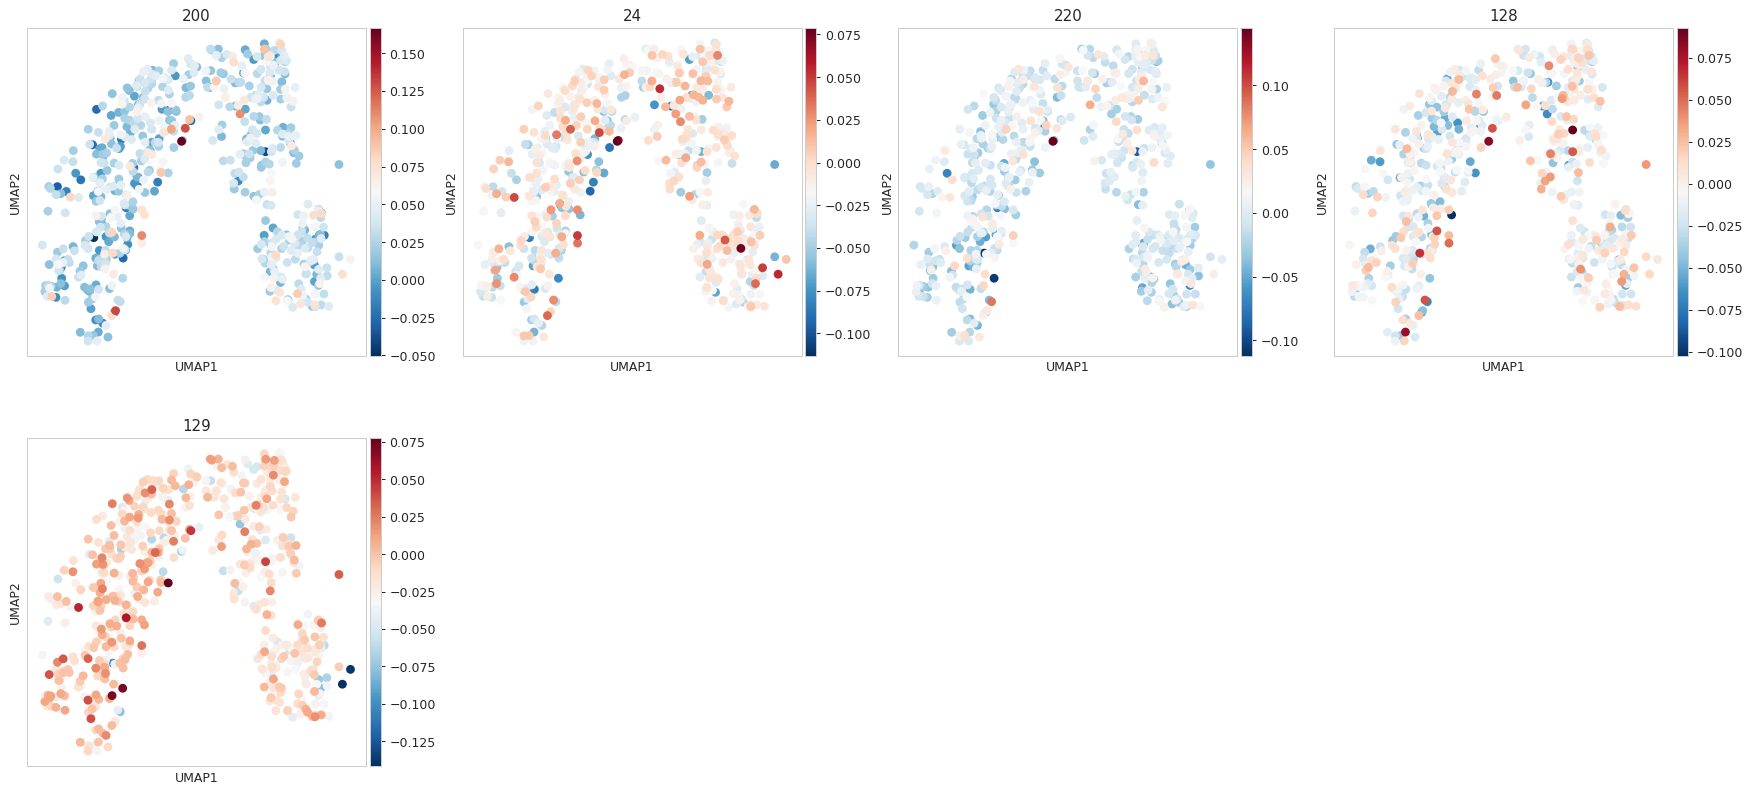

In [337]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5
sc.pl.umap(ad, color=scores_kmers.var(axis=0).sort_values(ascending=False).index[:5], cmap='RdBu_r')

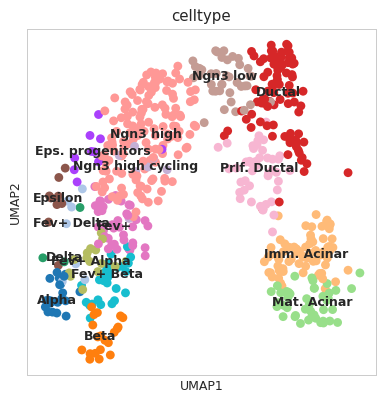

In [338]:
sc.pl.umap(ad, color='celltype', legend_loc='on data')

In [339]:
diff_by_celltype = {}
for c in set(ad.obs['celltype']):
    ad1 = ad[ad.obs['celltype'] == c,:]
    ad2 = ad[ad.obs['celltype'] != c,:]
    s1 = ad1.obs.mean()[ad1.obsm['kmers'].columns]
    s2 = ad2.obs.mean()[ad2.obsm['kmers'].columns]
    diff_by_celltype[c] = s1 - s2
diff_by_celltype = pd.DataFrame(diff_by_celltype)

In [340]:
sel_idx = set()
for c in diff_by_celltype:
    idx = np.argmax(diff_by_celltype[c])
    print(c, idx)
    sel_idx.add(idx)

Epsilon 171
Ngn3 high 34
Prlf. Ductal 128
Fev+ 129
Fev+ Delta 180
Fev+ Beta 115
Delta 175
Fev+ Alpha 115
Ductal 192
Eps. progenitors 56
Beta 118
Alpha 130
Ngn3 low 200
Ngn3 high cycling 21
Mat. Acinar 200
Imm. Acinar 153


In [341]:
sel_idx = sorted(list(sel_idx))
sel_idx

[21, 34, 56, 115, 118, 128, 129, 130, 153, 171, 175, 180, 192, 200]

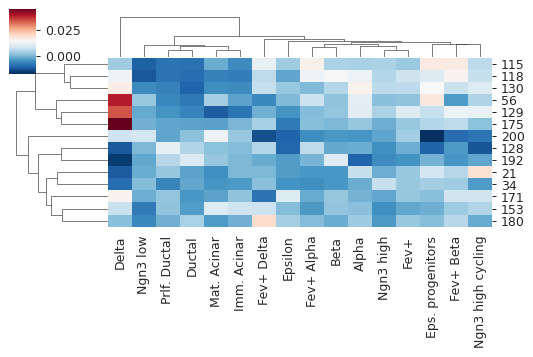

In [342]:
sns.clustermap(diff_by_celltype.reindex(sel_idx), cmap='RdBu_r', figsize=[6, 4])

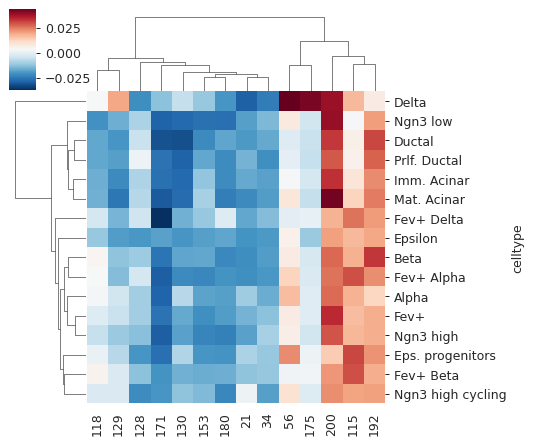

In [343]:
sns.clustermap(ad.obs.groupby('celltype').mean()[sel_idx], cmap='RdBu_r', figsize=[6, 5])

### This is the relatedness graph and used for dynamics filters learning

In [344]:
# sum(adata.obs_names.isin(df.index)

In [345]:
ad.shape, (~zero_counts).sum()

((600, 894), 894)

In [346]:
if ad.shape[1] != (~zero_counts).sum():
    ad = ad[:,~zero_counts].copy()

In [347]:
rel = ad.uns['neighbors']['connectivities'].A
# rel[:n_cells,:n_cells].sum()
rel.shape
rel.sum()

174.60417

In [348]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

n_batch = len(set(dataset.batch))
n_batch

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [349]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [350]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [351]:
len(reduced_groups)
selected_groups = [r for i, r in enumerate(reduced_groups) if i in sel_idx]
len(selected_groups)

14

In [352]:
sel_idx

[21, 34, 56, 115, 118, 128, 129, 130, 153, 171, 175, 180, 192, 200]

In [422]:
# n_kernels = len(selected_groups)
n_kernels = len(pwms)
# n_kernels = 8

## The parameter log_dynamic defines whether a kNN-graph will be used

True
12
0 out of 288...
(5, 12) (0, 0) 1
(5, 12) (0, 1) 1
(5, 12) (0, 2) 1
(5, 12) (0, 3) 1
(5, 12) (0, 4) 1
(5, 12) (0, 5) 1
(5, 12) (0, 6) 1
(5, 12) (0, 7) 1
(5, 12) (0, 8) 1


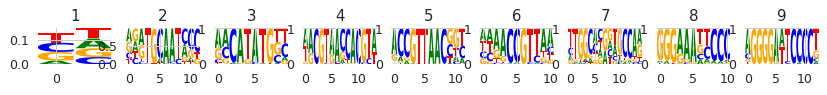

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
setting grad status of kernel (mono, dinuc) at 11 to (0, 0)
setting grad status of kernel (mono, dinuc) at 12 to (0, 0)
setting grad status of kernel (mono, dinuc) at 13 to (0, 0)
setting grad status of kernel (mono, dinuc) at 14 to (0, 0)
setting grad status of ke

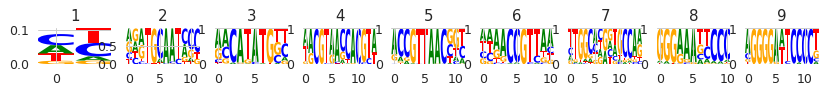

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
setting grad status of kernel (mono, dinuc) at 11 to (0, 0)
setting grad status of kernel (mono, dinuc) at 12 to (0, 0)
setting grad status of kernel (mono, dinuc) at 13 to (0, 0)
setting grad status of kernel (mono, dinuc) at 14 to (0, 0)
setting grad status of ke

In [512]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 150

for optimize_log_dynamic in [False, True]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(selected_groups):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.conv(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    if optimize_log_dynamic:
        model.selex_module.conn_sparse = torch.tensor(ad.uns['neighbors']['connectivities'].A).to_sparse().requires_grad_(True).cuda()
        model.selex_module.log_dynamic = tnn.Parameter(torch.rand(model.selex_module.conn_sparse.indices().shape[1])) # .cuda()
        model = model.cuda()
        model.selex_module.log_dynamic.shape

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1, optimiser=topti.Adam,
                                                skip_kernels=range(2, 500),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

False


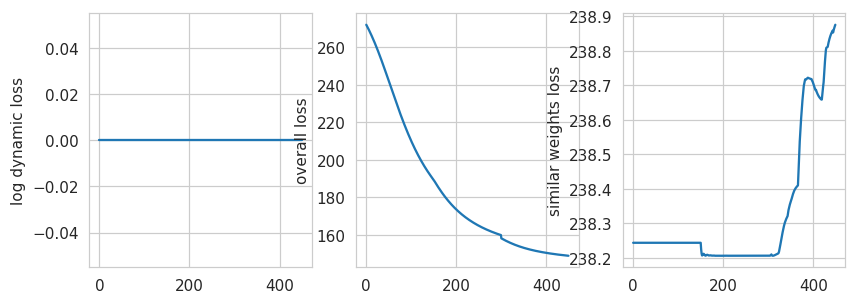

True


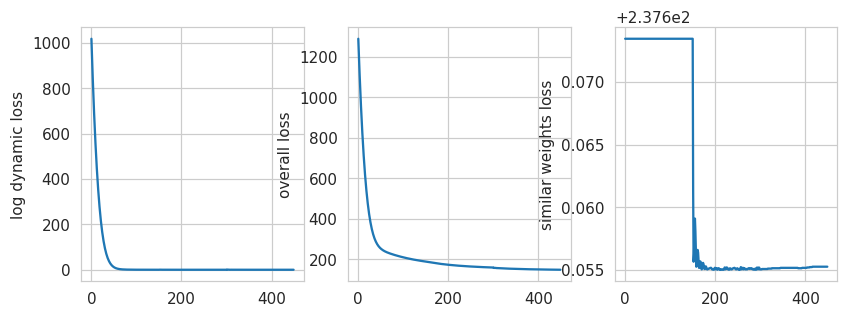

In [513]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    plt.subplot(1, 4, 1)
    plt.plot(model.loss_history_log_dynamic)
    plt.ylabel('log dynamic loss')
    plt.subplot(1, 4, 2)
    plt.plot(model.loss_history)
    plt.ylabel('overall loss')
    plt.subplot(1, 4, 3)
    plt.plot(model.loss_history_sym_weights)
    plt.ylabel('similar weights loss')
    plt.show()

False
True
3
0 out of 288...
(6, 3) (0, 0) 1
(6, 3) (1, 1) 1
(6, 3) (1, 2) 1
(6, 3) (1, 0) 1
(6, 3) (2, 1) 1
(6, 3) (2, 2) 1
(6, 3) (2, 0) 1
(6, 3) (3, 1) 1
(6, 3) (3, 2) 1


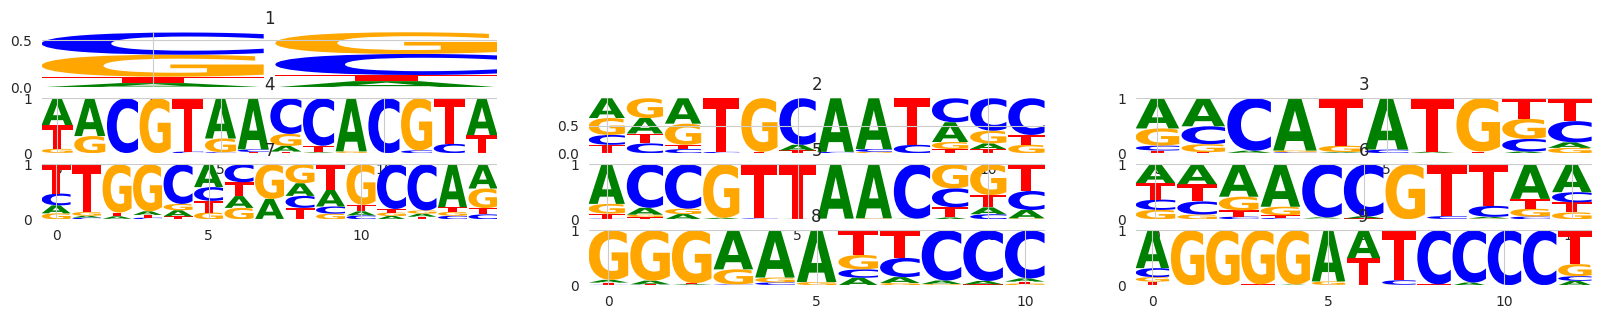

True
True
3
0 out of 288...
(6, 3) (0, 0) 1
(6, 3) (1, 1) 1
(6, 3) (1, 2) 1
(6, 3) (1, 0) 1
(6, 3) (2, 1) 1
(6, 3) (2, 2) 1
(6, 3) (2, 0) 1
(6, 3) (3, 1) 1
(6, 3) (3, 2) 1


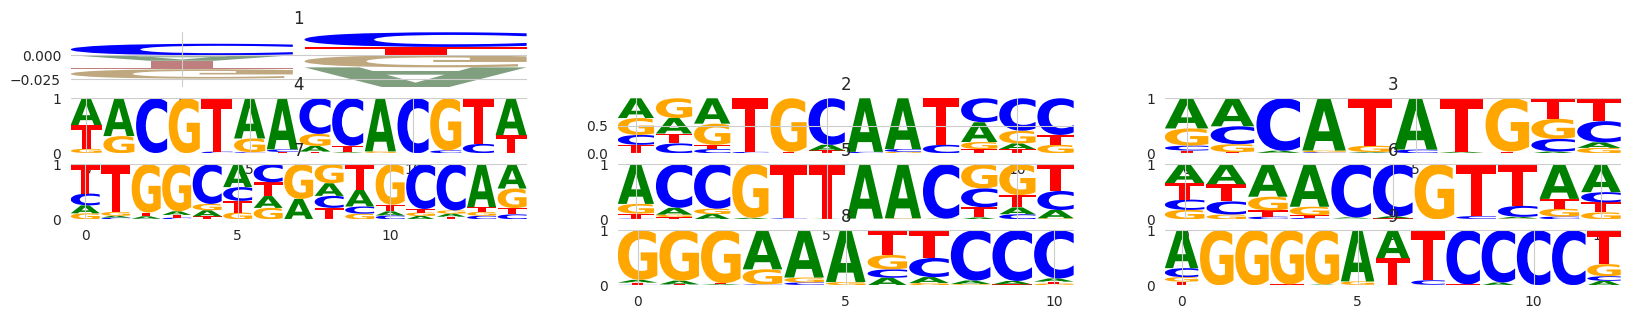

In [515]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.conv(model, n_cols=3, show=True, n_rows=6, stop_at=10)
    plt.show()


True


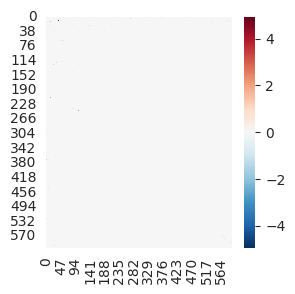

In [516]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.selex_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.selex_module.log_dynamic
    D = model.selex_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

False
True


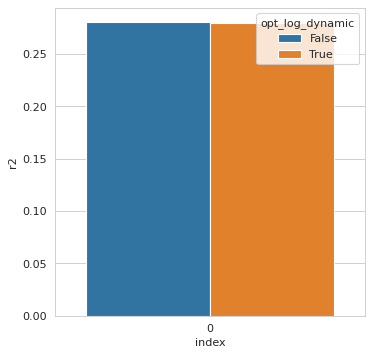

In [517]:
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

r2_all = pd.concat(r2_all)
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic')
plt.show()

In [518]:
model.binding_modes.prob_act

Parameter containing:
tensor([-2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83, -2.83,
        -2.83, -2.83, -2.83, -2.83, -2.83,

In [523]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [528]:


#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
# mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
# sns.displot(dynamic_score, height=3, aspect=1.2)
# plt.xlabel('dynamic score (normalized)')


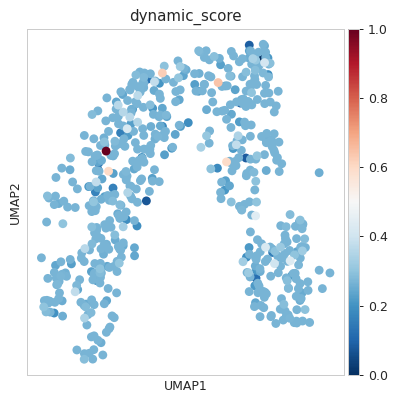

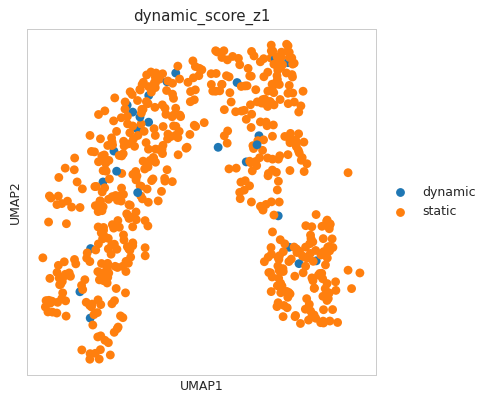

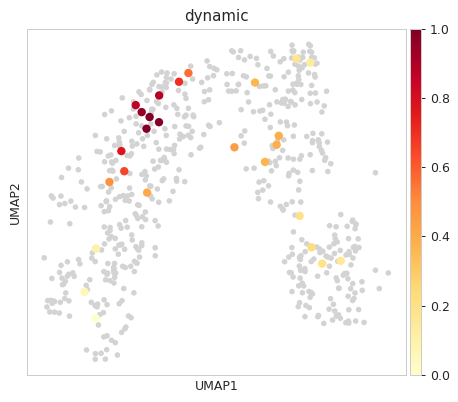

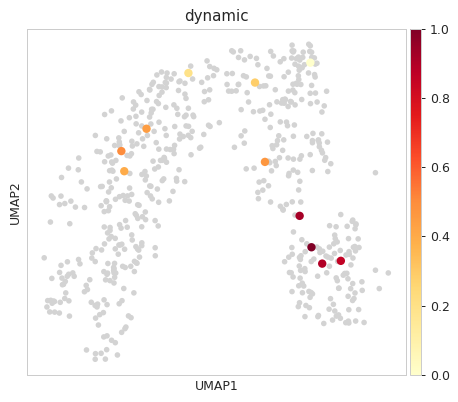

In [529]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

False


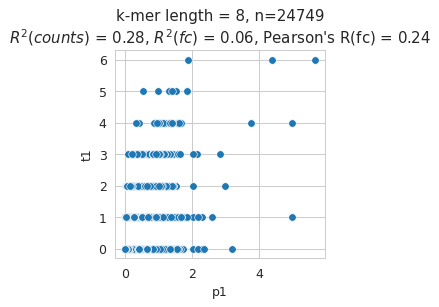

True
3
0 out of 288...
(12, 3) (0, 0) 1
(12, 3) (1, 1) 1
(12, 3) (1, 2) 1
(12, 3) (1, 0) 1
(12, 3) (2, 1) 1
(12, 3) (2, 2) 1
(12, 3) (2, 0) 1
(12, 3) (3, 1) 1
(12, 3) (3, 2) 1
10 out of 288...
(12, 3) (3, 0) 1
(12, 3) (4, 1) 1
(12, 3) (4, 2) 1
(12, 3) (4, 0) 1
(12, 3) (5, 1) 1
(12, 3) (5, 2) 1
(12, 3) (5, 0) 1
(12, 3) (6, 1) 1
(12, 3) (6, 2) 1
(12, 3) (6, 0) 1


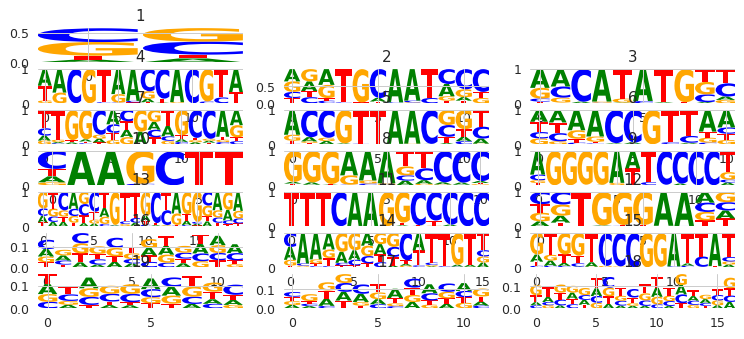

True


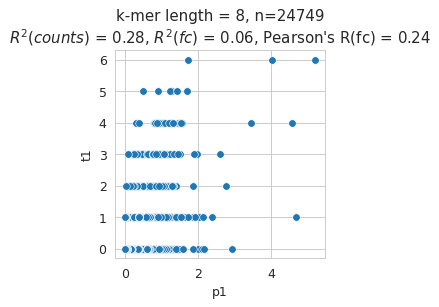

True
3
0 out of 288...
(12, 3) (0, 0) 1
(12, 3) (1, 1) 1
(12, 3) (1, 2) 1
(12, 3) (1, 0) 1
(12, 3) (2, 1) 1
(12, 3) (2, 2) 1
(12, 3) (2, 0) 1
(12, 3) (3, 1) 1
(12, 3) (3, 2) 1
10 out of 288...
(12, 3) (3, 0) 1
(12, 3) (4, 1) 1
(12, 3) (4, 2) 1
(12, 3) (4, 0) 1
(12, 3) (5, 1) 1
(12, 3) (5, 2) 1
(12, 3) (5, 0) 1
(12, 3) (6, 1) 1
(12, 3) (6, 2) 1
(12, 3) (6, 0) 1


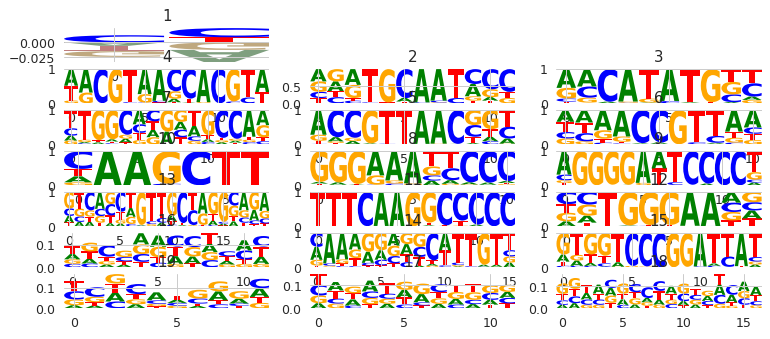

In [530]:
for optimize_log_dynamic in model_by_logdynamic:
    mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
    plt.show()

    mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
    mb.pl.conv(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=12,
               n_cols=3,
               stop_at=20) # n_cols=len(reduced_groups))
    plt.show()


False
True
here...
(894, 600)
41865.008


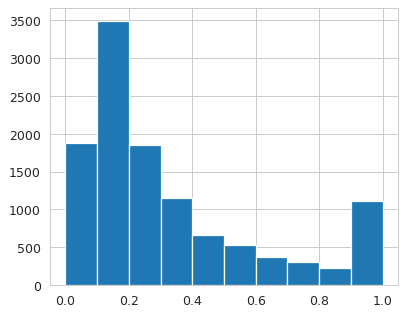

computing velocity graph (using 1/16 cores)


  0%|          | 0/600 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


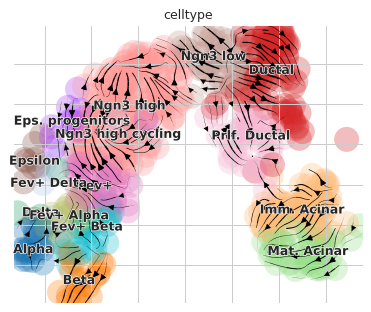

In [531]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    pred = np.concatenate(pred).T
    ad.layers['velocity'] = pred
    ad.layers['counts'] = ad.X

    mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    plt.hist(model.selex_module.conn_sparse.values().detach().cpu().numpy())
    plt.show()

    import scvelo as scv

    sc.pp.neighbors(ad)

    scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    scv.pl.velocity_embedding_stream(ad, color='celltype') #  X_grid='X_umap', V=V)

In [532]:
rna = sc.read_h5ad(rna_path)
rna.shape
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape
anno = mb.datasets.archetypes_anno()

In [533]:
rna_sel.shape

(600, 14663)

False


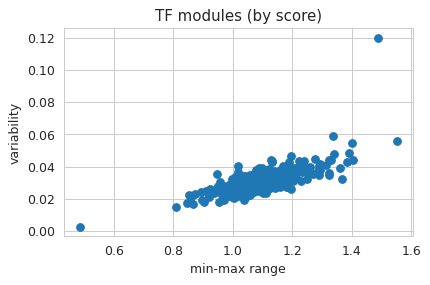

True


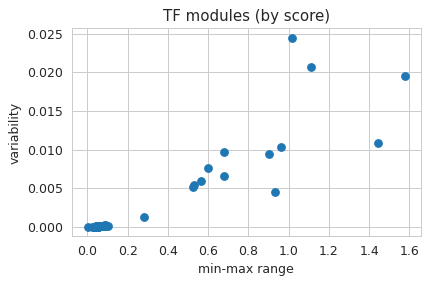

In [534]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

In [535]:
anno.sort_values('Cluster_ID')

Cluster_ID          Name          DBD             Seed_motif  \
61            1          HD/1  homeodomain     LHX6_homeodomain_3   
72            2          HD/2  homeodomain          ALX3_MA0634.1   
79            3          HD/3  homeodomain    VENTX_homeodomain_2   
80            4          HD/4  homeodomain  BARX1_MOUSE.H11MO.0.C   
81            5          HD/5  homeodomain    BARX1_homeodomain_1   
..          ...           ...          ...                    ...   
163         282         PAX/2          PAX   PAX5_HUMAN.H11MO.0.A   
161         283  PAX-halfsite          PAX          Pax2_MA0067.1   
0           284           AHR         bHLH    AHR_HUMAN.H11MO.0.B   
105         285      KLF/SP/3         C2H2   KLF8_HUMAN.H11MO.0.C   
285         286        ZSCAN4         C2H2          ZSCAN4_C2H2_1   

     Total_width  Consensus_left  Consensus_right  Cluster_size  
61            12               0               12             2  
72            26               8               16           186  
79            21               3               20             1  
80            17               5               13            17  
81            21               2               18             6  
..           ...             ...              ...           ...  
163           24               4               21             3  
161            8               1                7             1  
0              9               2                8             3  
105            9               0                9             2  
285           15               1               14             2  

[286 rows x 8 columns]

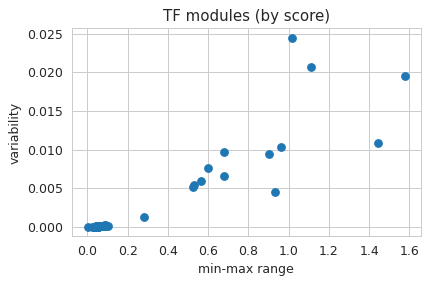

(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,) (600,)
(600,)

In [536]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])


In [537]:
res.sort_values('spearman', ascending=False)

opt_log_dynamic archetype_id  spearman     p_val
97              True           96  0.008396  0.837389
282             True          281  0.007652  0.851622
252             True          251  0.006483  0.874091
113             True          112  0.006150  0.880509
67              True           66  0.005569  0.891713
..               ...          ...       ...       ...
247             True          246 -0.027136  0.507059
196             True          195 -0.027487  0.501574
154             True          153 -0.028701  0.482869
188             True          187 -0.028914  0.479615
2               True            1 -0.030451  0.456574

[288 rows x 4 columns]

In [538]:
log_act

intercept  dinuc_bias         1         2         3  \
AAAGGTTAGGCTACAT-1-0  -0.000102   -0.008864 -0.093242 -0.083646 -0.167201   
AAATGCCTCAATACGC-1-0   0.000078    0.003914  0.035369  0.019045  0.053128   
AACAGCAAGAATGACG-1-0  -0.000075   -0.005483 -0.088880 -0.053660 -0.107573   
AACCTCCTCTAACTGA-1-0  -0.000055   -0.004140 -0.084941 -0.055449 -0.046715   
AACGGTAAGGGACTAA-1-0  -0.000206   -0.014260 -0.141545 -0.099819 -0.158644   
...                         ...         ...       ...       ...       ...   
TTGTTTGGTTCAAGAT-1-1  -0.000070   -0.004966 -0.076090 -0.049319 -0.085078   
TTTATGGAGTCACTCC-1-1  -0.000098   -0.007096 -0.091667 -0.066866 -0.101974   
TTTCTTGCATCGCTCC-1-1   0.000099    0.005520  0.047950  0.023946  0.059791   
TTTGACTTCTCGACCT-1-1  -0.000035   -0.002997 -0.043662 -0.032556 -0.057371   
TTTGTGTTCTCAATGA-1-1  -0.000026   -0.002464 -0.026843 -0.026632 -0.030940   

                             4         5         6         7         8  ...  \
AAAGGTTAGGCTACAT-1-0 -0.114159 -0.117331 -0.144878 -0.109610 -0.174142  ...   
AAATGCCTCAATACGC-1-0  0.058905 -0.013369  0.018663  0.036087  0.067574  ...   
AACAGCAAGAATGACG-1-0 -0.096086 -0.046186 -0.093482 -0.068133 -0.094062  ...   
AACCTCCTCTAACTGA-1-0 -0.076746 -0.039864 -0.053338 -0.022777 -0.005181  ...   
AACGGTAAGGGACTAA-1-0 -0.180997 -0.102062 -0.136716 -0.131111 -0.165487  ...   
...                        ...       ...       ...       ...       ...  ...   
TTGTTTGGTTCAAGAT-1-1 -0.090408 -0.041126 -0.073804 -0.057390 -0.084690  ...   
TTTATGGAGTCACTCC-1-1 -0.118758 -0.056689 -0.085356 -0.069738 -0.091594  ...   
TTTCTTGCATCGCTCC-1-1  0.069036  0.001755  0.050150  0.056813  0.084910  ...   
TTTGACTTCTCGACCT-1-1 -0.046949 -0.036485 -0.056394 -0.037969 -0.057117  ...   
TTTGTGTTCTCAATGA-1-1 -0.022480 -0.034913 -0.054099 -0.032964 -0.037773  ...   

                           277       278       279       280       281  \
AAAGGTTAGGCTACAT-1-0 -0.003961 -0.012359 -0.008337 -0.013783 -0.007482   
AAATGCCTCAATACGC-1-0  0.017466  0.002669  0.005068  0.003180 -0.001389   
AACAGCAAGAATGACG-1-0 -0.011060 -0.006079 -0.005957 -0.006696 -0.002369   
AACCTCCTCTAACTGA-1-0 -0.008221 -0.004428 -0.004371 -0.004834 -0.001662   
AACGGTAAGGGACTAA-1-0 -0.027493 -0.015656 -0.015055 -0.017868 -0.005651   
...                        ...       ...       ...       ...       ...   
TTGTTTGGTTCAAGAT-1-1 -0.010844 -0.005345 -0.005229 -0.006152 -0.002026   
TTTATGGAGTCACTCC-1-1 -0.014145 -0.007690 -0.007660 -0.008794 -0.002561   
TTTCTTGCATCGCTCC-1-1  0.019281  0.004698  0.006707  0.005727 -0.000185   
TTTGACTTCTCGACCT-1-1 -0.003539 -0.003519 -0.002822 -0.004100 -0.001940   
TTTGTGTTCTCAATGA-1-1 -0.001116 -0.003018 -0.001979 -0.003531 -0.002072   

                           282       283       284       285       286  
AAAGGTTAGGCTACAT-1-0 -0.008806 -0.007585 -0.008889 -0.012866 -0.008770  
AAATGCCTCAATACGC-1-0  0.002977  0.004181  0.006660  0.001314 -0.000091  
AACAGCAAGAATGACG-1-0 -0.004856 -0.004871 -0.006722 -0.005725 -0.003556  
AACCTCCTCTAACTGA-1-0 -0.003307 -0.003516 -0.005089 -0.004351 -0.002626  
AACGGTAAGGGACTAA-1-0 -0.012627 -0.013187 -0.017513 -0.014812 -0.009065  
...                        ...       ...       ...       ...       ...  
TTGTTTGGTTCAAGAT-1-1 -0.004292 -0.004456 -0.006056 -0.005123 -0.002987  
TTTATGGAGTCACTCC-1-1 -0.006340 -0.006524 -0.008969 -0.007322 -0.004436  
TTTCTTGCATCGCTCC-1-1  0.004777  0.005653  0.008206  0.003371  0.001466  
TTTGACTTCTCGACCT-1-1 -0.002720 -0.002539 -0.002973 -0.003766 -0.002417  
TTTGTGTTCTCAATGA-1-1 -0.002167 -0.001994 -0.001906 -0.003504 -0.002383  

[600 rows x 288 columns]

In [626]:
res = pd.DataFrame(pd.concat([delta, var], axis=1))
res['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
res['archetypes_name'] = res['name'].map(anno.set_index('Cluster_ID')['Name'])
res['archetypes_seed'] = res['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
res = res.sort_values(0, ascending=0)
res

0             1       name archetypes_name  \
10         1.576336  1.956883e-02         10           HD/10   
8          1.444294  1.088851e-02          8            HD/8   
12         1.109538  2.071607e-02         12           HD/12   
13         1.014874  2.445497e-02         13             NFY   
14         0.963467  1.031843e-02         14           CUX/1   
...             ...           ...        ...             ...   
177        0.032903  1.920231e-05        177          ZNF423   
20         0.032706  1.941684e-05         20           HD/15   
197        0.028180  1.224247e-05        197          ZNF586   
222        0.027637  1.265846e-05        222          ZNF784   
intercept  0.000684  8.739386e-09  intercept             NaN   

                 archetypes_seed  
10         HNF1A_HUMAN.H11MO.0.C  
8           ALX1_HUMAN.H11MO.0.B  
12          PBX1_HUMAN.H11MO.0.A  
13                  Dux_MA0611.1  
14                    CUX1_CUT_3  
...                          ...  
177              Znf423_MA0116.1  
20          HXA1_HUMAN.H11MO.0.C  
197        ZN586_HUMAN.H11MO.0.C  
222                ZNF784_C2H2_1  
intercept                    NaN  

[288 rows x 5 columns]

<AxesSubplot: xlabel='0', ylabel='archetypes_name'>

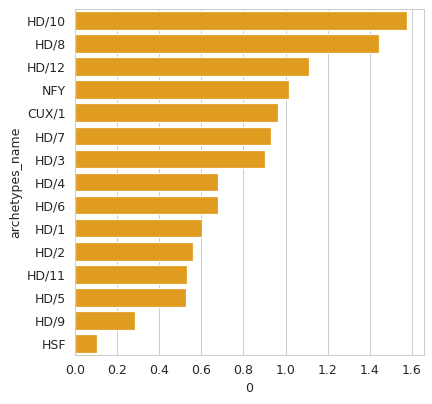

In [661]:
rcParams['figure.figsize'] = 5, 5
sns.barplot(data=res.head(15), x=0, y='archetypes_name', color='orange')

In [627]:
res.head(20)

0         1 name archetypes_name        archetypes_seed
10   1.576336  0.019569   10           HD/10  HNF1A_HUMAN.H11MO.0.C
8    1.444294  0.010889    8            HD/8   ALX1_HUMAN.H11MO.0.B
12   1.109538  0.020716   12           HD/12   PBX1_HUMAN.H11MO.0.A
13   1.014874  0.024455   13             NFY           Dux_MA0611.1
14   0.963467  0.010318   14           CUX/1             CUX1_CUT_3
7    0.930340  0.004537    7            HD/7     EMX1_homeodomain_2
3    0.902935  0.009378    3            HD/3    VENTX_homeodomain_2
4    0.677390  0.009728    4            HD/4  BARX1_MOUSE.H11MO.0.C
6    0.677058  0.006537    6            HD/6        BARHL2_MA0635.1
1    0.601009  0.007549    1            HD/1     LHX6_homeodomain_3
2    0.562540  0.005883    2            HD/2          ALX3_MA0634.1
11   0.529803  0.005409   11           HD/11    MEOX2_homeodomain_3
5    0.525396  0.005160    5            HD/5    BARX1_homeodomain_1
9    0.283413  0.001310    9            HD/9          Lhx3_MA0135.1
249  0.102790  0.000129  249             HSF             HSF1_HSF_1
181  0.090214  0.000142  181             GFI  GFI1B_HUMAN.H11MO.0.A
31   0.086295  0.000212   31            NR/2  NR2E3_HUMAN.H11MO.0.C
258  0.085595  0.000128  258            GRHL            GRHL1_CP2_1
238  0.085500  0.000193  238           PROX1         PROX1_MA0794.1
247  0.084170  0.000148  247           RFX/1   RFX1_HUMAN.H11MO.0.B

In [649]:
model.binding_modes

BindingModesSimple(
  (conv_mono): ModuleList(
    (0): None
    (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
    (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
    (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
    (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
    (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
    (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (8): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
    (9): Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
    (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
    (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
    (12): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
    (13): Conv2d(1, 1, kernel_size=(4, 8), stride=(1, 1), bias=False)
    (14): Conv2d(1, 1, kernel

True
1
0 out of 288...
40 1 0 (40, 1) (1, 0) 1
40 1 0 (40, 1) (2, 0) 1
40 1 0 (40, 1) (3, 0) 1
40 1 0 (40, 1) (4, 0) 1
40 1 0 (40, 1) (5, 0) 1
40 1 0 (40, 1) (6, 0) 1
40 1 0 (40, 1) (7, 0) 1
40 1 0 (40, 1) (8, 0) 1
40 1 0 (40, 1) (9, 0) 1
10 out of 288...
40 1 0 (40, 1) (10, 0) 1
40 1 0 (40, 1) (11, 0) 1
40 1 0 (40, 1) (12, 0) 1
40 1 0 (40, 1) (13, 0) 1
40 1 0 (40, 1) (14, 0) 1
40 1 0 (40, 1) (15, 0) 1
40 1 0 (40, 1) (16, 0) 1
40 1 0 (40, 1) (17, 0) 1
40 1 0 (40, 1) (18, 0) 1
40 1 0 (40, 1) (19, 0) 1


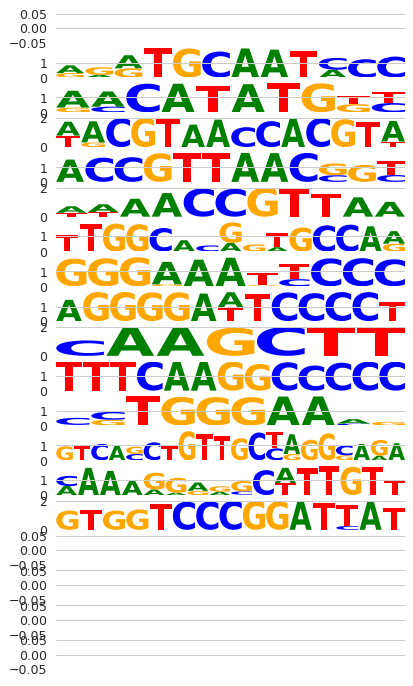

In [657]:
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
0 out of 288...
(40, 1) (1, 0) 1
0
        0    1    2        3    4    5    6
A  0.0000  2.0  2.0  0.00000  0.0  0.0  0.0
C  1.0614  0.0  0.0  0.00000  2.0  0.0  0.0
G  0.0000  0.0  0.0  1.93587  0.0  0.0  0.0
T  0.0000  0.0  0.0  0.00000  0.0  2.0  2.0
(40, 1) (2, 0) 1
1
         0         1         2         3        4         5         6   \
A  0.000000  0.000000  0.000000  1.506422  1.78099  1.913263  0.000000   
C  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
G  1.850253  1.872621  1.943765  0.130361  0.00000  0.000000  0.065266   
T  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.843798   

         7         8         9        10  
A  0.000000  0.000000  0.000000  0.00000  
C  0.477526  1.869446  1.882102  1.80777  
G  0.000000  0.000000  0.000000  0.00000  
T  1.008682  0.000000  0.000000  0.00000  
(40, 1) (3, 0) 1
2
          0         1         2         3        4         5         6  \
A  0.000000  0.000000  0.000000  0.00000

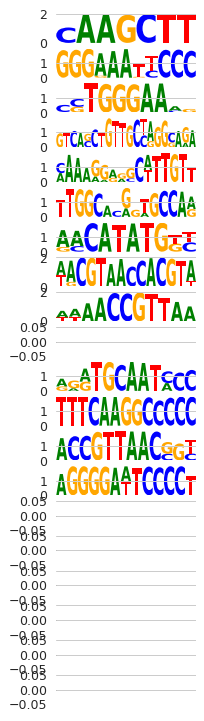

<Figure size 180x1800 with 0 Axes>

In [643]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [542]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 16.820648


In [543]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [544]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [545]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [546]:
from scipy.stats import spearmanr

In [565]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')

res = []
print(len(all_targets))
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    log_act = ad.obsm['log_activities'][k].values
    for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
        # print(ki)
        if ki % 10 == 0:
            print(ki)
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        # for t in all_targets:
        for t in set(all_targets).intersection(next_targets):
            gex = rna_sel.X[:,rna_sel.var_names == t]
            assert gex.shape[1] == 1
            gex = gex.A.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

False
True
3828
False
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
True
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


In [ ]:
res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())

In [566]:
res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])

In [567]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

opt_log_dynamic  archetype_id gene_name  matched  spearman  \
6               False             2    Arxes2     True  0.124091   
12              False             2      Fen1     True  0.204530   
14              False             2      Isl1     True -0.177147   
16              False             2      Gen1     True  0.125588   
25              False             2     Mien1     True -0.112228   
...               ...           ...       ...      ...       ...   
8757             True           257  Trp53bp2     True  0.115453   
8772             True           262    Zbtb7c     True -0.158210   
8780             True           264     Rap2a     True -0.107996   
8788             True           281   Pax6os1     True -0.187526   
8789             True           281      Pax6     True -0.213308   

             p_val     p_adj  
6     2.326528e-03  0.038676  
12    4.349216e-07  0.000061  
14    1.272842e-05  0.000761  
16    2.055686e-03  0.035940  
25    5.923845e-03  0.070684  
...            ...       ...  
8757  4.631812e-03  0.059463  
8772  9.950457e-05  0.003838  
8780  8.106931e-03  0.085482  
8788  3.747126e-06  0.000311  
8789  1.328305e-07  0.000023  

[899 rows x 7 columns]

In [568]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot('k', 'opt_log_dynamic', 'spearman')
df2['matched'] = res.pivot('k', 'opt_log_dynamic', 'matched')[False]

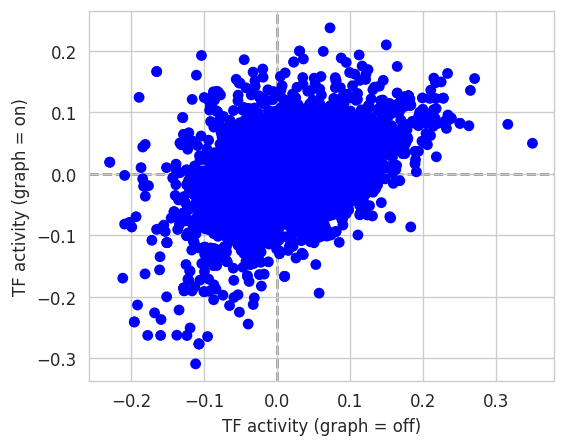

In [569]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
df2 = df2.sort_values('matched', ascending=True)
plt.scatter(df2[False], df2[True],
            color=np.where(df2['matched'], 'blue', 'gray'),
            s=np.where(df2['matched'], 30, 5))
plt.xlabel('TF activity (graph = off)')
plt.ylabel('TF activity (graph = on)')
plt.axhline(0, color='gray', ls='--', zorder=0)
plt.axvline(0, color='gray', ls='--', zorder=0)


In [570]:
df2[df2['matched'] == True].sort_values(True, ascending=False)

opt_log_dynamic     False      True  matched
k                                           
Krt8_70          0.072758  0.237051     True
Stmn1_70         0.149907  0.209403     True
Sox4_93          0.031024  0.199347     True
Sox4_89          0.031024  0.199347     True
Smarce1_248      0.063516  0.198866     True
...                   ...       ...      ...
Mafb_50         -0.106867 -0.276648     True
Mafb_55         -0.106867 -0.276648     True
Mafb_53         -0.106867 -0.276648     True
Entpd3_70       -0.111513 -0.309019     True
Tmem151a_70           NaN       NaN     True

[4397 rows x 3 columns]

False


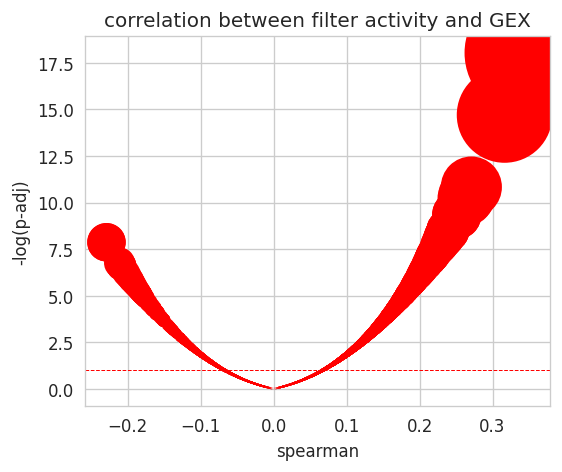

True


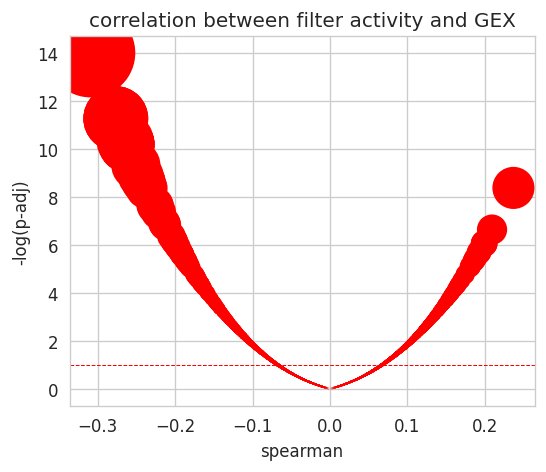

In [571]:
for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    print(optimize_log_dynamic)
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 3), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('correlation between filter activity and GEX')
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

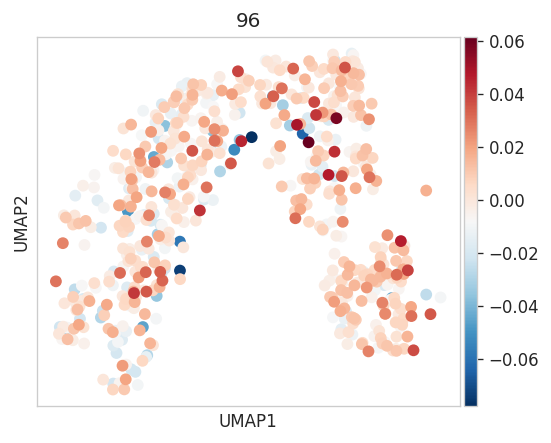

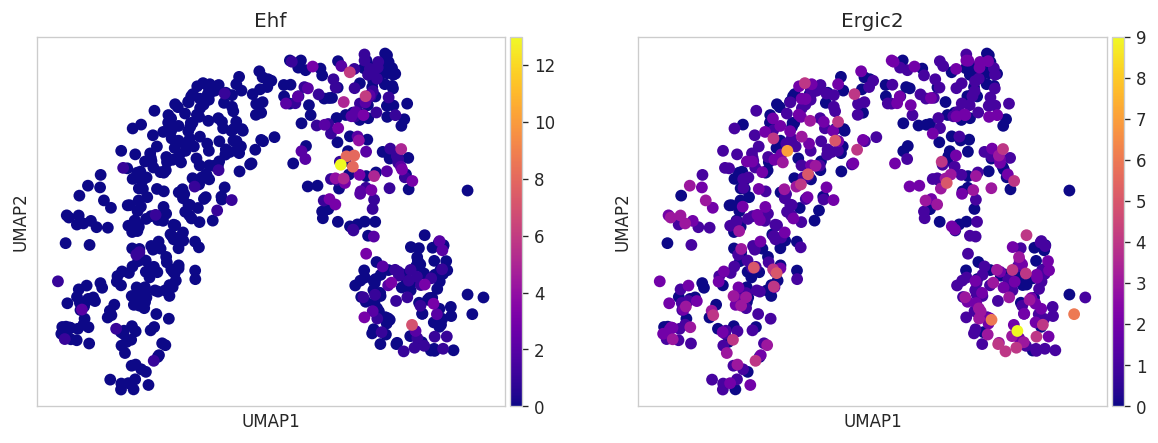

In [572]:
sc.pl.umap(ad, color=[96], cmap='RdBu_r')
sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

In [573]:
res[res['p_val'] < 0.1]

opt_log_dynamic  archetype_id gene_name  matched  spearman  \
0               False             2     Psen2     True  0.081708   
4               False             2     Dusp7     True  0.070457   
6               False             2    Arxes2     True  0.124091   
12              False             2      Fen1     True  0.204530   
14              False             2      Isl1     True -0.177147   
...               ...           ...       ...      ...       ...   
8785             True           277     Gmeb2     True -0.071291   
8787             True           278     Gmeb2     True -0.071291   
8788             True           281   Pax6os1     True -0.187526   
8789             True           281      Pax6     True -0.213308   
8793             True           285      Klf8     True -0.095008   

             p_val     p_adj            k  
0     4.543540e-02  0.243782      Psen2_2  
4     8.463744e-02  0.342365      Dusp7_2  
6     2.326528e-03  0.038676     Arxes2_2  
12    4.349216e-07  0.000061       Fen1_2  
14    1.272842e-05  0.000761       Isl1_2  
...            ...       ...          ...  
8785  8.101115e-02  0.333058    Gmeb2_277  
8787  8.101115e-02  0.333058    Gmeb2_278  
8788  3.747126e-06  0.000311  Pax6os1_281  
8789  1.328305e-07  0.000023     Pax6_281  
8793  1.993255e-02  0.151632     Klf8_285  

[2338 rows x 8 columns]

In [584]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

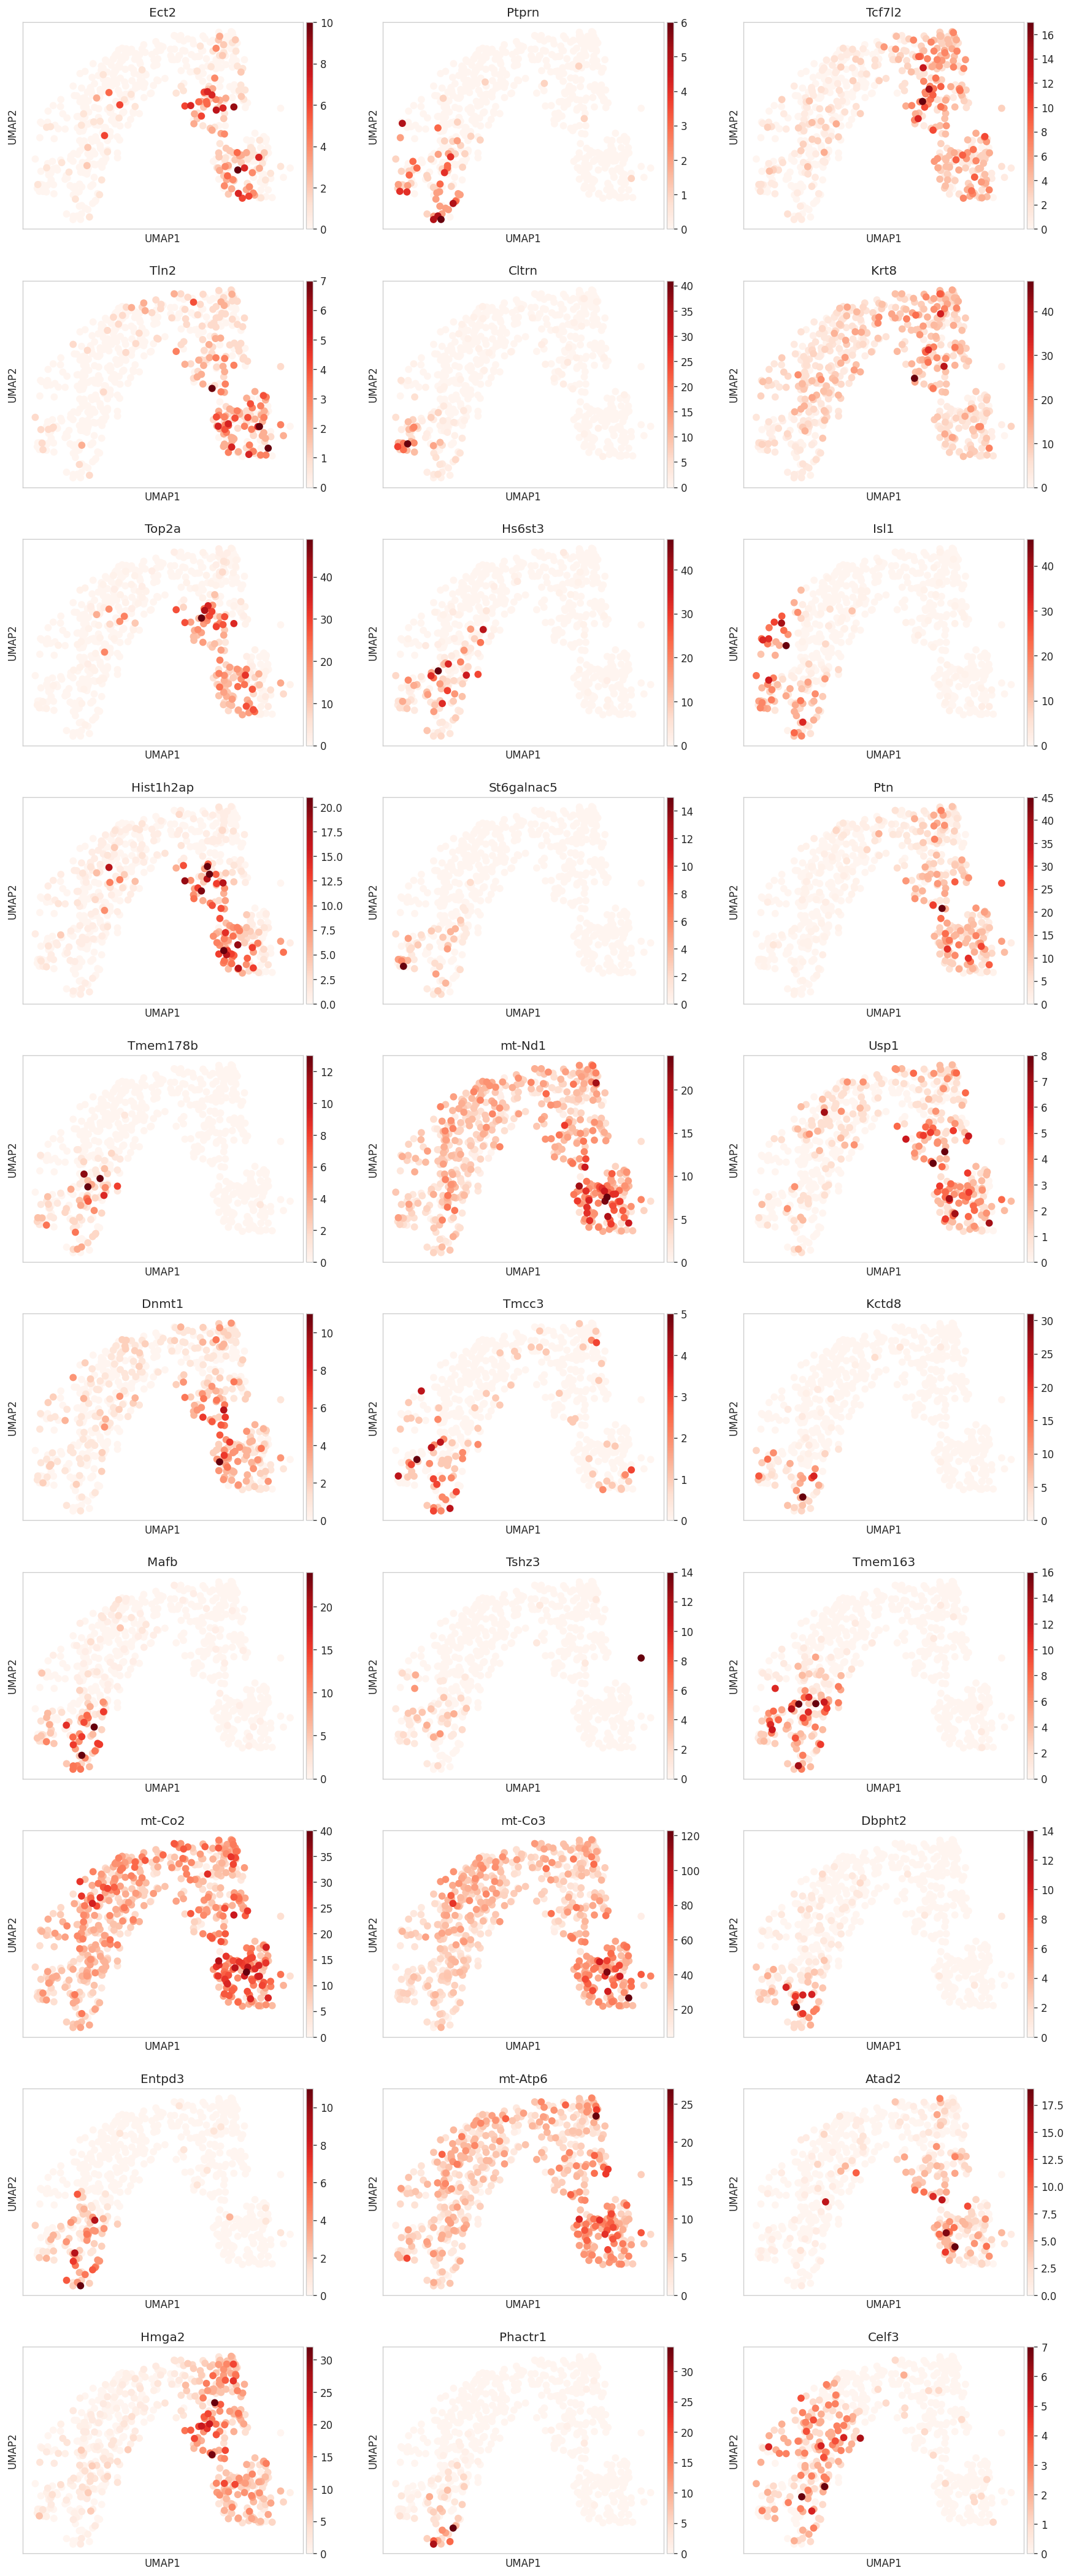

In [585]:
sc.pl.umap(rna_sel, color=sel_genes,
           cmap='Reds', ncols=3)


In [586]:
import anndata
ad_act = anndata.AnnData(ad.obsm['log_activities'])
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

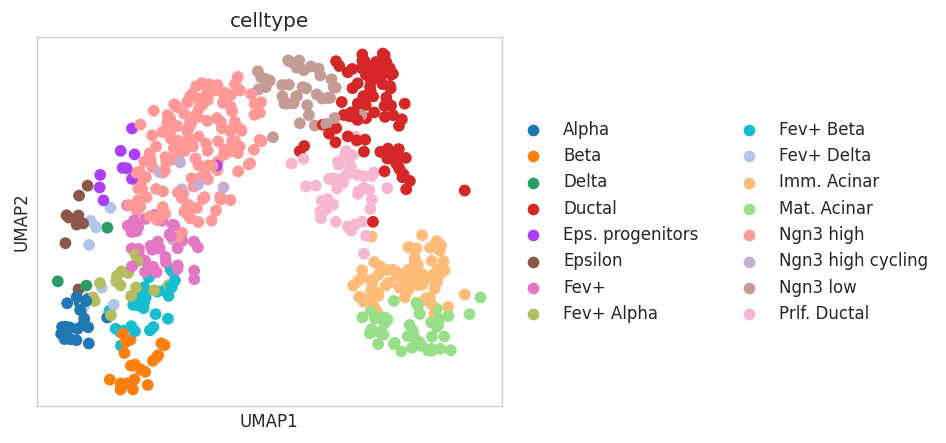

In [587]:
sc.pl.umap(ad_act, color='celltype')


Rank genes groups using the annotation

In [588]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
rkg_df = []
for ct in ad_act.obs['celltype'].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2['celltype'] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Ngn3 low
Prlf. Ductal
Ductal
Ngn3 high
Imm. Acinar
Alpha
Fev+
Fev+ Alpha
Epsilon
Fev+ Beta
Eps. progenitors
Beta
Fev+ Delta
Ngn3 high cycling
Mat. Acinar
Delta


names    scores  logfoldchanges     pvals  pvals_adj  celltype module_name
0    12  3.725150             NaN  0.000608   0.025016  Ngn3 low       HD/12
1   228  3.620366             NaN  0.000717   0.025016  Ngn3 low      ZNF431
2     4  3.502758             NaN  0.001058   0.025016  Ngn3 low        HD/4
3   200  3.489915             NaN  0.001056   0.025016  Ngn3 low       CENBP
4    31  3.474339             NaN  0.001103   0.025016  Ngn3 low        NR/2

Get top modules

In [589]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

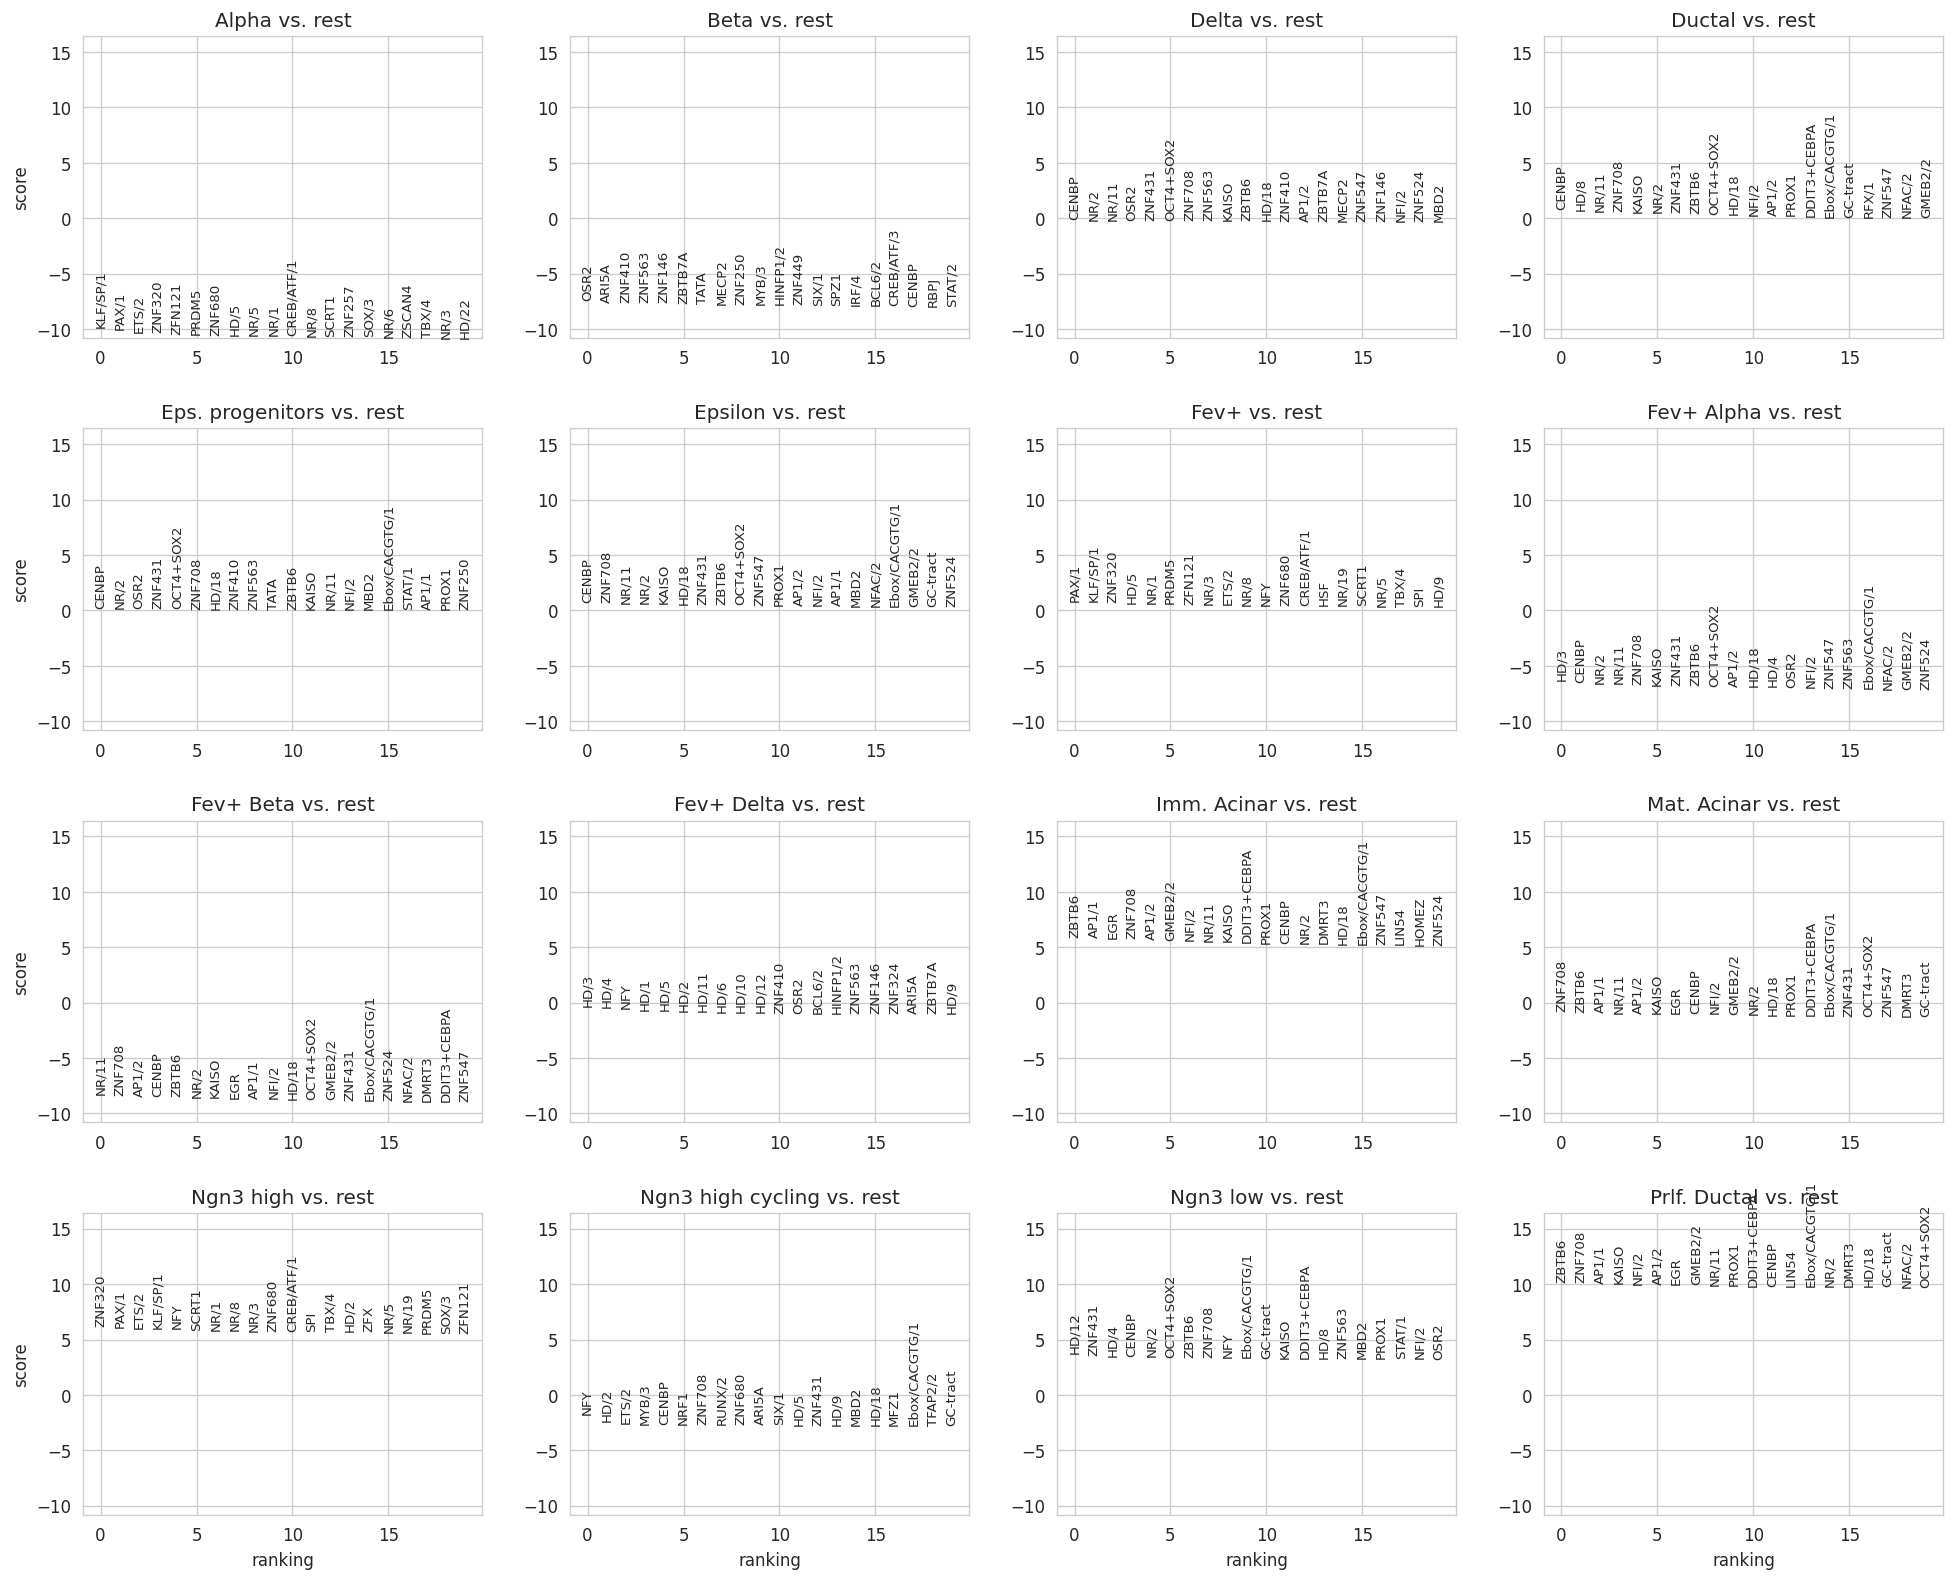

In [590]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
sc.pl.rank_genes_groups(ad_act)


In [610]:
len(set(res[(res['p_adj'] < 1e-5)]['k']))

38

In [612]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Atad2_70',
 'Celf3_96',
 'Celf3_98',
 'Cltrn_70',
 'Dbpht2_52',
 'Dbpht2_70',
 'Dnmt1_70',
 'Ect2_70',
 'Entpd3_70',
 'Hist1h2ap_70',
 'Hmga2_71',
 'Hmga2_73',
 'Hs6st3_70',
 'Isl1_2',
 'Kctd8_70',
 'Krt8_70',
 'Mafb_50',
 'Mafb_53',
 'Mafb_55',
 'Phactr1_70',
 'Ptn_70',
 'Ptprn_70',
 'St6galnac5_70',
 'Tcf7l2_120',
 'Tcf7l2_29',
 'Tcf7l2_70',
 'Tln2_70',
 'Tmcc3_70',
 'Tmem163_70',
 'Tmem178b_70',
 'Top2a_70',
 'Tshz3_70',
 'Usp1_109',
 'Usp1_112',
 'mt-Atp6_70',
 'mt-Co2_70',
 'mt-Co3_70',
 'mt-Nd1_70'}

In [606]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

opt_log_dynamic  archetype_id gene_name  matched  spearman  \
4411             True             2      Isl1     True -0.262700   
34              False             7      Fen1     True  0.204530   
12              False             2      Fen1     True  0.204530   
14              False             2      Isl1     True -0.177147   
4421             True             2       Arx     True -0.142882   
...               ...           ...       ...      ...       ...   
70              False            24    Arid3a     True -0.004766   
4417             True             2    Dlx1as     True  0.003205   
4416             True             2      Gbx1     True  0.002105   
21              False             2      Pdx1     True -0.000123   
68              False            21      Pdx1     True -0.000123   

             p_val         p_adj          k module_name  
4411  6.296032e-11  4.126835e-08     Isl1_2        HD/2  
34    4.349216e-07  6.070953e-05     Fen1_7        HD/7  
12    4.349216e-07  6.070953e-05     Fen1_2        HD/2  
14    1.272842e-05  7.614540e-04     Isl1_2        HD/2  
4421  4.470843e-04  1.209741e-02      Arx_2        HD/2  
...            ...           ...        ...         ...  
70    9.072554e-01  9.716073e-01  Arid3a_24       HD/18  
4417  9.375608e-01  9.816537e-01   Dlx1as_2        HD/2  
4416  9.589711e-01  9.877796e-01     Gbx1_2        HD/2  
21    9.975997e-01  9.991904e-01     Pdx1_2        HD/2  
68    9.975997e-01  9.991904e-01    Pdx1_21       HD/16  

[116 rows x 9 columns]

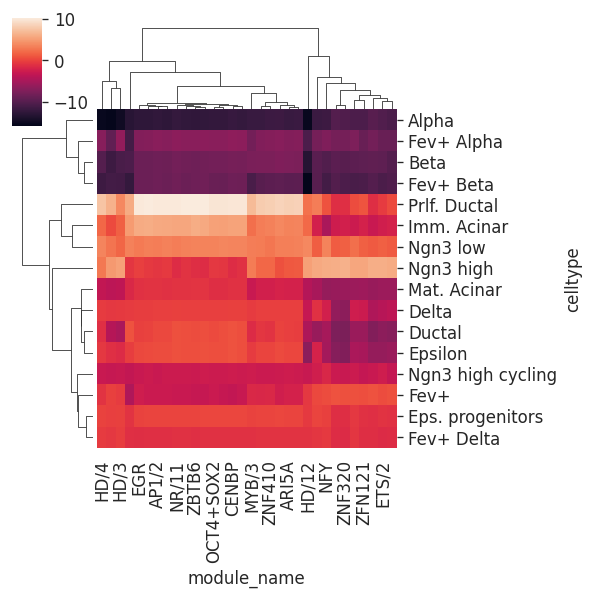

In [591]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby('celltype').head(5)['module_name'])
sns.clustermap(rkg_df[rkg_df['module_name'].isin(mod_names_best)].pivot('celltype', 'module_name', 'scores'), figsize=[5, 5])


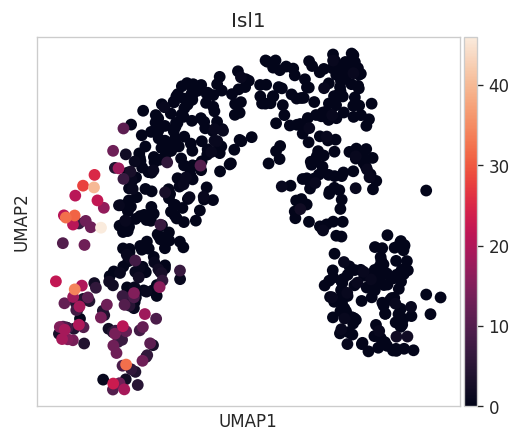

In [617]:
sc.pl.umap(rna_sel, color='Isl1')


In [623]:
rna_sel['Ehf']

KeyError: 'Ehf'

In [687]:
from matplotlib import rcParams, cm
cmap = cm.get_cmap('YlOrRd')
cmap.set_over('black')
cmap.set_under('lightgray')

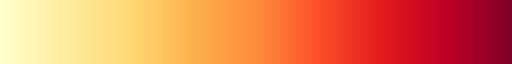

In [688]:
cmap

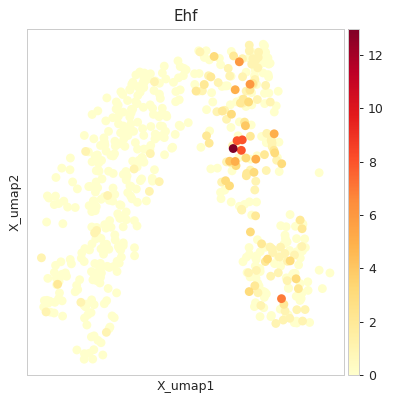

In [689]:
sc.pl.embedding(rna_sel, basis='X_umap', color='Ehf', color_map=cmap)
